In [16]:
# visualizing reference and moving masks
%matplotlib qt
ref_dir = input("Enter the reference CNMF directory (e.g. in vivo/slice/first dipping):")
mov_dir = input("Enter the moving CNMF directory (e.g. wellsN01):")
n = input("Enter match order (pythonic, should be N-1 for dipping):")
n = int(n)

Enter the reference CNMF directory (e.g. in vivo/slice/first dipping): /mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/slice/preprocessing/20230817_SL1PL55_slice_maddy_done_qc_done/
Enter the moving CNMF directory (e.g. wellsN01): /mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells101/preprocessing/20230817_SL1PL55_wells101_maddy_done_qc_done/
Enter match order (pythonic, should be N-1 for dipping): 1


In [17]:
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor

import contextlib
import joblib
from tqdm import tqdm

n_cores = 35

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [18]:
%%time
## LOADING EVERYTHING UP - TAKES ~20 sec

# load packages

import napari
from magicgui import magicgui, widgets
import time

from IPython import get_ipython
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix
from scipy import signal as sg
from scipy.ndimage import center_of_mass
import scipy
import pickle

from tifffile.tifffile import imwrite,imread
from tqdm.auto import tqdm,trange

from copy import deepcopy
import h5py

import caiman as cm
from caiman.source_extraction.cnmf import cnmf,params
from caiman.paths import caiman_datadir
from caiman.utils.visualization import get_contours

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

def load_pickle(file_path):
    """
    Load a dictionary from a pickle file.

    Args:
    - file_path (str): Path to the pickle file.

    Returns:
    - dict: Loaded dictionary.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# CNMFE model
cnmf_ref_path = os.path.join(ref_dir, 'ch0_means_movie_nobg_cnmf_merged_refit.hdf5')
cnmf_mov_path = os.path.join(mov_dir, 'ch0_means_movie_nobg_cnmf_merged_refit.hdf5')

# CNMFE model
cnmf_ref = cnmf.load_CNMF(cnmf_ref_path, 
                            n_processes=1,
                            dview=None)
cnmf_mov = cnmf.load_CNMF(cnmf_mov_path, 
                            n_processes=1,
                            dview=None)

# Line up all static inputs
spcomps_r = np.reshape(cnmf_ref.estimates.A.toarray(),cnmf_ref.estimates.dims + (-1,),order='F')
spcomps_r = spcomps_r.transpose([3,2,0,1]).astype(np.float32)
CY_r = cnmf_ref.estimates.C + cnmf_ref.estimates.YrA # temporal loadings
spcomps_m = np.reshape(cnmf_mov.estimates.A.toarray(),cnmf_mov.estimates.dims + (-1,),order='F')
spcomps_m = spcomps_m.transpose([3,2,0,1]).astype(np.float32)
CY_m = cnmf_mov.estimates.C + cnmf_mov.estimates.YrA # temporal loadings
print(f"Successfully loaded merged/refit CNMF model")

cnmf_ref_path_v1 = os.path.join(ref_dir, 'ch0_means_movie_nobg_cnmf.hdf5')
cnmf_mov_path_v1 = os.path.join(mov_dir, 'ch0_means_movie_nobg_cnmf.hdf5')

# CNMFE model
cnmf_ref_v1 = cnmf.load_CNMF(cnmf_ref_path_v1, 
                            n_processes=1,
                            dview=None)
cnmf_mov_v1 = cnmf.load_CNMF(cnmf_mov_path_v1, 
                            n_processes=1,
                            dview=None)

spcomps_r_v1 = np.reshape(cnmf_ref_v1.estimates.A.toarray(),cnmf_ref_v1.estimates.dims + (-1,),order='F')
spcomps_r_v1 = spcomps_r_v1.transpose([3,2,0,1]).astype(np.float32)
CY_r_v1 = cnmf_ref_v1.estimates.C + cnmf_ref_v1.estimates.YrA # temporal loadings
spcomps_m_v1 = np.reshape(cnmf_mov_v1.estimates.A.toarray(),cnmf_mov_v1.estimates.dims + (-1,),order='F')
spcomps_m_v1 = spcomps_m_v1.transpose([3,2,0,1]).astype(np.float32)
CY_m_v1 = cnmf_mov_v1.estimates.C + cnmf_mov_v1.estimates.YrA # temporal loadings

CYsav_r_v1 = cnmf_ref_v1.estimates.CYsav # smoothened CY curve
CYsavsort_r_v1 = np.sort(CYsav_r_v1,axis=1)
CYsavb10_r_v1 = np.mean(CYsavsort_r_v1[:,:int(np.ceil(CYsavsort_r_v1.shape[1]/10))],axis=1) # bottom 10% mean

CYsav_m_v1 = cnmf_mov_v1.estimates.CYsav # smoothened CY curve
CYsavsort_m_v1 = np.sort(CYsav_m_v1,axis=1)
CYsavb10_m_v1 = np.mean(CYsavsort_m_v1[:,:int(np.ceil(CYsavsort_m_v1.shape[1]/10))],axis=1) # bottom 10% mean
print(f"Successfully loaded unmerged CNMF model")

mc_memmapped_fname_r = [i for i in os.listdir(ref_dir) if 'memmap__' in i][0]
Yr_r, dims_r, T_r = cm.load_memmap(ref_dir + mc_memmapped_fname_r)
images_r = np.array(np.reshape(Yr_r.T, [T_r] + list(dims_r), order='F')) 

mc_memmapped_fname_m = [i for i in os.listdir(mov_dir) if 'memmap__' in i][0]
Yr_m, dims_m, T_m = cm.load_memmap(mov_dir + mc_memmapped_fname_m)
images_m = np.array(np.reshape(Yr_m.T, [T_m] + list(dims_m), order='F')) 
print(f"Successfully loaded data")

save_path = 'ch0_means_movie_nobg_compfilt.pickle'
ori_path = 'ch0_means_movie_nobg_compfilt_ori.pickle'

if save_path in os.listdir(ref_dir):
    vars_dict1_ref = load_pickle(os.path.join(ref_dir, save_path))
    # duplicated original version if not already saved
    if ori_path not in os.listdir(ref_dir):
        with open(os.path.join(ref_dir,ori_path), 'wb') as f:
            pickle.dump(vars_dict1_ref, f)
else:
    print('Ref file not clicked!')
if save_path in os.listdir(mov_dir):
    vars_dict1_mov = load_pickle(os.path.join(mov_dir, save_path))
    # duplicate original version if not already saved
    if ori_path not in os.listdir(mov_dir):
        with open(os.path.join(mov_dir,ori_path), 'wb') as f:
            pickle.dump(vars_dict1_mov, f)
else:
    print('Mov file not clicked!')

base_dir = r'/mnt/ssd_cache/pkalugin/stitch_warp'
warp_dir = os.path.join(base_dir,os.path.split(os.path.dirname(ref_dir))[1].split('_')[0] + '_' + os.path.split(os.path.dirname(ref_dir))[1].split('_')[1])
if n==0:
    dfield_path = warp_dir + f'/bigwarp dfield.tif'
else:
    dfield_path = warp_dir + f'/bigwarp dfield{n:01}.tif'
dfield = imread(dfield_path)
# will need to adjust this to several moving images per group!
ref_img = imread(warp_dir + r'/' + [f for f in os.listdir(warp_dir) if 'fr0_coor' in f][0])
mov_img = imread(warp_dir + r'/' + [f for f in os.listdir(warp_dir) if f'fr{n+1:01}_coor_rot' in f][0])

import SimpleITK as sitk

displacement_image = sitk.GetImageFromArray(np.double(dfield.transpose([0,2,3,1])),sitk.sitkVectorFloat64)

tx = sitk.DisplacementFieldTransform(displacement_image)
tx.SetInterpolator(sitk.sitkLinear)

mov_img_d = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(np.double(mov_img)),tx))

print(mov_img_d.shape)
print(ref_img.shape)
shape_keep = ()
for i in range(len(ref_img.shape)):
    shape_keep += (np.min([ref_img.shape[i],mov_img_d.shape[i]]),)
print(shape_keep)
mov_img_d = mov_img_d[:shape_keep[0],:shape_keep[1],:shape_keep[2]]
ref_img = ref_img[:shape_keep[0],:shape_keep[1],:shape_keep[2]]
print(mov_img_d.shape)
print(ref_img.shape)
print(spcomps_m.shape)
print(spcomps_m_v1.shape)
print(images_m.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Successfully loaded merged/refit CNMF model
Successfully loaded unmerged CNMF model
Successfully loaded data
(21, 412, 463)
(24, 437, 496)
(21, 412, 463)
(21, 412, 463)
(21, 412, 463)
(147, 21, 412, 463)
(890, 21, 412, 463)
(78, 412, 463, 21)
CPU times: user 5.19 s, sys: 46.5 s, total: 51.7 s
Wall time: 1min 51s


In [19]:
# this part just performs the bigstitcher rigid body move on the spcomps_m
# will need to adjust for multiple moving images
from scipy.ndimage import affine_transform
import xml.etree.ElementTree as ET
base_dir = r'/mnt/ssd_cache/pkalugin/stitch_warp'

spcomps_m_rot = np.zeros(spcomps_m.shape)
images_m_rot = np.zeros(images_m.shape)

if n==0:
    tree = ET.parse(warp_dir+f'/dataset.xml')
else:
    tree = ET.parse(warp_dir+f'/dataset{n:01}.xml')
root = tree.getroot()
w_mat = np.array(root[2][1][0][1].text.split()).astype(np.float64).reshape([3,4])
w_mat_i = np.linalg.inv(np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0))
w_mat[0,3] = w_mat_i[1,3]
w_mat[1,3] = w_mat_i[0,3]

def rot_img(img):
    img_rot = affine_transform(img,w_mat)
    return img_rot

def warp_img(img):
    img_warp = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(np.double(img)),tx))
    return img_warp

with tqdm_joblib(tqdm(desc="Rotating...", total=len(range(spcomps_m.shape[0])))) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(rot_img)(spcomps_m[ncomp,...].transpose([1,2,0])) for ncomp in range(spcomps_m.shape[0]))

spcomps_m_rot = np.asarray(results).transpose([0,3,1,2])
del results

#for ncomp in trange(spcomps_m.shape[0]):
#    spcomps_m_rot[ncomp,...] = affine_transform(spcomps_m[ncomp,...].transpose([1,2,0]),w_mat).transpose([2,0,1])

with tqdm_joblib(tqdm(desc="Rotating...", total=len(range(images_m.shape[0])))) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(rot_img)(images_m[nfr,...]) for nfr in range(images_m.shape[0]))

images_m_rot = np.asarray(results)
del results

#for nfr in trange(images_m.shape[0]):
#    images_m_rot[nfr,...] = affine_transform(images_m[nfr,...],w_mat)

print(f"Setup done")

Rotating...:   0%|          | 0/147 [00:00<?, ?it/s]

Rotating...:   0%|          | 0/78 [00:00<?, ?it/s]

Setup done


In [20]:
%%time
spcomps_m_rot[spcomps_m_rot<0.001] = 0
spcomps_m_warp = np.zeros(spcomps_m_rot.shape)
images_m_warp = np.zeros(images_m_rot.shape)

for ncomp in trange(spcomps_m.shape[0]):
    spcomps_m_warp[ncomp,...] = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(np.double(spcomps_m_rot[ncomp,...])),tx))

for nfr in trange(images_m.shape[0]):
    images_m_warp[nfr,...] = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(np.double(images_m_rot[nfr,...].transpose([2,0,1]))),tx)).transpose([1,2,0])

spcomps_r = spcomps_r[:,:shape_keep[0],:shape_keep[1],:shape_keep[2]]
spcomps_m_rot = spcomps_m_rot[:,:shape_keep[0],:shape_keep[1],:shape_keep[2]]
spcomps_m_warp = spcomps_m_warp[:,:shape_keep[0],:shape_keep[1],:shape_keep[2]]

images_r = images_r[:,:shape_keep[1],:shape_keep[2],:shape_keep[0]]
images_m_rot = images_m_rot[:,:shape_keep[1],:shape_keep[2],:shape_keep[0]]
images_m_warp = images_m_warp[:,:shape_keep[1],:shape_keep[2],:shape_keep[0]]

spcomps_r_e = np.concatenate((np.zeros(spcomps_r[0,...][np.newaxis,...].shape,dtype=np.float32),spcomps_r))
spcomps_r_e2 = np.argmax(spcomps_r_e,axis=0)
spcomps_m_rot_e = np.concatenate((np.zeros(spcomps_m_rot[0,...][np.newaxis,...].shape,dtype=np.float32),spcomps_m_rot.astype(np.float32)))
spcomps_m_rot_e2 = np.argmax(spcomps_m_rot_e,axis=0)
spcomps_m_warp_e = np.concatenate((np.zeros(spcomps_m_warp[0,...][np.newaxis,...].shape,dtype=np.float32),spcomps_m_warp.astype(np.float32)))
spcomps_m_warp_e2 = np.argmax(spcomps_m_warp_e,axis=0)

coms_r = np.zeros((spcomps_r.shape[0],3))
for ncomp in trange(spcomps_r.shape[0]):
    coms_r[ncomp,...] = center_of_mass(spcomps_r[ncomp,...])

coms_m_warp = np.zeros((spcomps_m_warp.shape[0],3))
for ncomp in trange(spcomps_m_warp.shape[0]):
    coms_m_warp[ncomp,...] = center_of_mass(spcomps_m_warp[ncomp,...])

spcomps_r_l = np.zeros(spcomps_r.shape).astype('int')
for ncomp in trange(spcomps_r.shape[0]):
    spcomps_r_l[ncomp,...] = spcomps_r[ncomp,...]>0

spcomps_m_rot_l = np.zeros(spcomps_m_rot.shape).astype('int')
for ncomp in trange(spcomps_m_rot.shape[0]):
    spcomps_m_rot_l[ncomp,...] = spcomps_m_rot[ncomp,...]>0

spcomps_m_warp_l = np.zeros(spcomps_m_warp.shape).astype('int')
for ncomp in trange(spcomps_m_warp.shape[0]):
    spcomps_m_warp_l[ncomp,...] = spcomps_m_warp[ncomp,...]>0

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

/mnt/colab/colab_shared/anaconda3/envs/caiman_test/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

CPU times: user 3min 2s, sys: 9.6 s, total: 3min 11s
Wall time: 1min 20s


In [21]:
%%time
spcomps_r_f = np.reshape(spcomps_r,(spcomps_r.shape[0],) + (-1,))
spcomps_m_warp_f = np.reshape(spcomps_m_warp,(spcomps_m_warp.shape[0],) + (-1,))
A_corr = np.matmul(spcomps_r_f,spcomps_m_warp_f.T)
SOL_refs = [np.where(A_corr[i,:]>0)[0][np.argsort(-A_corr[i,np.where(A_corr[i,:]>0)]).tolist()[0]].tolist() for i in range(A_corr.shape[0])]
SOL_movs = [np.where(A_corr[:,i]>0)[0][np.argsort(-A_corr[np.where(A_corr[:,i]>0),i]).tolist()[0]].tolist() for i in range(A_corr.shape[1])]

if n==0:
    match_path = f'ch0_means_movie_nobg_compmatch.npy'
else:
    match_path = f'ch0_means_movie_nobg_compmatch{n:01}.npy'
if match_path in os.listdir(warp_dir):
    match_dict1 = np.load(os.path.join(warp_dir, match_path),allow_pickle=True)[()]
    print(match_dict1)
else:
    match_dict1 = {
        "Srefs": [x for x in list(np.argsort(-np.max(A_corr,axis=1))) if len(SOL_refs[x]) != 0], # list of refs to be searched (exclude those with zero matches)
        "Smovs": [x for x in list(np.argsort(-np.max(A_corr,axis=0))) if len(SOL_movs[x]) != 0], # list of movs to be searched (exclude those with zero matches)
        "SOL_refs_f": SOL_refs, # mov search list for given ref (possibly filtered later)
        "SOL_movs_f": SOL_movs, # ref search list for given mov (possibly filtered later)
        "TmovsAllowed": [True for i in range(len(SOL_movs))], # whether given mov is allowed to be trashed (default True for all)
        "CSL": list(), # current search list
        "Mode": 0, # loop through components - 0 is ref, 1 is mov
        "Mpairs": list(), # list of matched pairs [ref,mov]
        "Mnotes": list(), # optional notes on the matched pairs
        "Mrefs_c": list(), # cumulative list of matched refs
        "Mmovs_c": list(), # cumulative list of matched movs
        "Mrefs": list(), # list of matched ref components (calculated at the end, grouped)
        "Mmovs": list(), # list of matched mov components (calculated at the end, grouped)
        "Trefs": [x for x in list(np.argsort(-np.max(A_corr,axis=1))) if len(SOL_refs[x]) == 0], # list of trashed refs
        "Tmovs": [x for x in list(np.argsort(-np.max(A_corr,axis=0))) if len(SOL_movs[x]) == 0], # list of trashed movs
        "CSLlabels": np.zeros(shape_keep).astype('int'), # image of remaining labels in search group
        "Mrefslabels": np.zeros(shape_keep).astype('int'), # image of ref labels matched
        "Mmovslabels": np.zeros(shape_keep).astype('int'), # image of mov labels matched
        "bypass": False # whether or not to bypass trash in next looper step
    }
    if len(match_dict1['Srefs']) != 0 and len(match_dict1['SOL_refs_f']) != 0:
        match_dict1['CSL'] = match_dict1['SOL_refs_f'][match_dict1['Srefs'][0]]
        for j in match_dict1['CSL']:
            match_dict1['CSLlabels'][spcomps_m_warp_e2 == j+1] = j+1
        print(match_dict1)
    else:
        print("ERROR!")

{'Srefs': [148, 158, 101, 8, 11, 25, 34, 27, 127, 35, 80, 139, 37, 116, 46, 56, 47, 24, 146, 60, 12, 118, 114, 39, 110, 155, 21, 29, 18, 122, 59, 133, 67, 81, 14, 108, 159, 85, 62, 15, 42, 10, 64, 151, 53, 136, 17, 71, 79, 82, 141, 84, 138, 111, 28, 98, 48, 74, 70, 51, 68, 144, 147, 61, 154, 26, 52, 36, 100, 142, 121, 41, 132, 40, 89, 57, 140, 99, 125, 38, 90, 152, 97, 104, 112, 123, 137, 150, 30, 119, 6, 103, 33, 117, 149, 134, 22, 120, 66, 113, 4, 32, 45, 2, 23, 75, 7, 16, 109, 1, 55, 130, 153, 76, 78, 63, 92, 105, 65, 58, 13, 115, 106, 43, 69, 143, 20, 44, 94, 72, 77, 31, 102, 50, 88, 0, 124, 3, 19, 83, 86], 'Smovs': [143, 36, 13, 12, 110, 93, 73, 92, 112, 130, 32, 72, 3, 85, 102, 109, 123, 126, 0, 82, 113, 103, 30, 53, 98, 114, 77, 144, 131, 6, 75, 142, 104, 39, 8, 122, 100, 17, 47, 58, 54, 133, 29, 21, 16, 91, 116, 46, 69, 94, 64, 97, 140, 118, 124, 139, 14, 52, 4, 67, 87, 129, 18, 111, 108, 23, 42, 57, 62, 56, 7, 2, 137, 101, 33, 138, 65, 15, 134, 90, 71, 107, 99, 22, 120, 88, 1,

In [24]:
# Initialize viewer and start GUI
images_r_b = np.broadcast_to(images_r,(images_m_rot.shape[0],) + images_r.shape)
images_m_warp_b = np.broadcast_to(images_m_warp,(images_r.shape[0],) + images_m_warp.shape)
images_m_rot_b = np.broadcast_to(images_m_rot,(images_r.shape[0],) + images_m_rot.shape)

viewer = napari.Viewer()
viewer.add_image(images_r_b.transpose([0,1,4,2,3]),name='cells ref',colormap='gray')
viewer.add_image(images_m_warp_b.transpose([1,0,4,2,3]),name='cells warp',colormap='gray',blending='additive')
viewer.add_image(images_m_rot_b.transpose([1,0,4,2,3]),name='cells rot',colormap='gray',visible=False)

viewer.add_labels(spcomps_r_e2,name='all components ref',visible=False)
viewer.add_labels(spcomps_m_warp_e2,name='all components mov',visible=False)
viewer.add_labels(spcomps_m_rot_e2,name='all components rot',visible=False)

match_dict2 = deepcopy(match_dict1)
match_dict3 = deepcopy(match_dict2)

# trash, next, match, undo functions
def clickM():
    global match_dict1, match_dict2, match_dict3
    if match_dict1['Mode'] == 0:
        match_dict1['Mrefs_c'] += [match_dict1['Srefs'][0]]
        match_dict1['Mmovs_c'] += [match_dict1['CSL'][0]]
        match_dict1['Mrefslabels'][spcomps_r_e2 == match_dict1['Srefs'][0]+1] = match_dict1['Srefs'][0]+1
        match_dict1['Mmovslabels'][spcomps_m_warp_e2 == match_dict1['CSL'][0]+1] = match_dict1['CSL'][0]+1
        match_dict1['Mpairs'].append([match_dict1['Srefs'][0],match_dict1['CSL'][0]])
        match_dict1['TmovsAllowed'][match_dict1['CSL'][0]] = False # matched mov component can no longer be trashed
    else:
        match_dict1['Mrefs_c'] += [match_dict1['CSL'][0]]
        match_dict1['Mmovs_c'] += [match_dict1['Smovs'][0]]
        match_dict1['Mrefslabels'][spcomps_r_e2 == match_dict1['CSL'][0]+1] = match_dict1['CSL'][0]+1
        match_dict1['Mmovslabels'][spcomps_m_warp_e2 == match_dict1['Smovs'][0]+1] = match_dict1['Smovs'][0]+1
        match_dict1['Mpairs'].append([match_dict1['CSL'][0],match_dict1['Smovs'][0]])
    match_dict1['CSL'] = list()
    match_dict1['bypass'] = True
    match_dict1['Mnotes'].append(note.value)
    clear_note()
    looper()

def clickN():
    global match_dict1, match_dict2, match_dict3
    match_dict1['CSL'] = match_dict1['CSL'][1:]
    looper()

def clickT():
    global match_dict1, match_dict2, match_dict3
    match_dict1['CSL'] = list()
    looper()

def clickU():
    global match_dict1, match_dict2, match_dict3
    # reverse vars_dict to one step back, then rerun looper
    note.value = match_dict1['Mnotes'][-1]
    match_dict1 = deepcopy(match_dict3)
    print_lab("Pressed undo")
    looper()

def looper(save=True):
    global match_dict1, match_dict2, match_dict3
    if save:
        match_dict3 = deepcopy(match_dict2)
        match_dict2 = deepcopy(match_dict1)

    if len(match_dict1['CSL']) == 0:
        if match_dict1['Mode'] == 0:
            if not match_dict1['bypass']:
                match_dict1['Trefs'] += [match_dict1['Srefs'][0]]
            match_dict1['bypass'] = False
            if len(match_dict1['Srefs']) <= 1:
                # transition to Mode 1
                print_lab("Transitioning modes...")
                match_dict1['Smovs'] = [x for x in match_dict1['Smovs'] if match_dict1['SOL_movs_f'][x][0] not in np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1]==x),0][0,...].tolist()]
                if len(match_dict1['Smovs']) > 0:
                    for i in match_dict1['Smovs']:
                        if not match_dict1['TmovsAllowed'][i]:
                            match_dict1['SOL_movs_f'][i] = match_dict1['SOL_movs_f'][i][0:np.min([match_dict1['SOL_movs_f'][i].index(x) for x in np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1]==i),0][0,...].tolist()])]
                for j in range(len(match_dict1['SOL_movs_f'])):
                    match_dict1['SOL_movs_f'][j] = [x for x in match_dict1['SOL_movs_f'][j] if x not in match_dict1['Trefs']]
                match_dict1['Mode'] = 1
                print_lab("")
            else:
                match_dict1['Srefs'] = match_dict1['Srefs'][1:]
                match_dict1['CSL'] = match_dict1['SOL_refs_f'][match_dict1['Srefs'][0]]
                match_dict1['CSLlabels'] = np.zeros(shape_keep).astype('int')
                for j in match_dict1['CSL']:
                    match_dict1['CSLlabels'][spcomps_m_warp_e2 == j+1] = j+1
                looper(save=False)
        else:
            if not match_dict1['bypass'] and match_dict1['TmovsAllowed'][match_dict1['Smovs'][0]]:
                match_dict1['Tmovs'] += [match_dict1['Smovs'][0]]
            match_dict1['bypass'] = False
            if len(match_dict1['Smovs']) <= 1:
                # finish
                print_lab("Finishing...")
                groups_list = list()
                for x in match_dict1['Mpairs']:
                    s = [x]
                    for y in groups_list[:]:
                        if (x[0] in [j[0] for j in y]) or (x[1] in [j[1] for j in y]):
                            s += y
                            groups_list.remove(y)
                    groups_list.append(s)
                for g in groups_list:
                    xg = list()
                    yg = list()
                    [xg.append(a[0]) for a in g if a[0] not in xg]
                    [yg.append(a[1]) for a in g if a[1] not in yg]
                    match_dict1['Mrefs'].append(xg)
                    match_dict1['Mmovs'].append(yg)
                print_lab("Congratulations - all done! Remember to press Save!")
            else:
                match_dict1['Smovs'] = match_dict1['Smovs'][1:]
                match_dict1['CSL'] = match_dict1['SOL_movs_f'][match_dict1['Smovs'][0]]
                match_dict1['CSLlabels'] = np.zeros(shape_keep).astype('int')
                for j in match_dict1['CSL']:
                    match_dict1['CSLlabels'][spcomps_r_e2 == j+1] = j+1
                looper(save=False)
    else:
        match_dict1['bypass'] = False
        replot()

def clickG():
    if viewer.layers['cells ref'].colormap.name == 'gray':
        viewer.layers['cells ref'].colormap = 'magenta'
        viewer.layers['cells rot'].colormap = 'green'
        viewer.layers['cells warp'].colormap = 'green'
    else:
        viewer.layers['cells ref'].colormap = 'gray'
        viewer.layers['cells rot'].colormap = 'gray'
        viewer.layers['cells warp'].colormap = 'gray'    

# important points to add:
# 1. main replot should make ref/mov timecourses on separate plots, weight distributions of both masks
# 2. in the case of matching to a component that already has a match, plot other matched timecourses with transparent lines
# 3. sliders plot to the same two windows, but should be cleared/invisible unless engaged! sliders plot to twin axis with dotted lines

# Clicker GUI that lives in napari and runs functions (part of initialization)
@magicgui(
    O={
        "choices": ("Trash", "Match", "Next", "Undo"),
        "allow_multiple": True,
    }
)
def clicker(O=("Match")):
    """Dropdown selection function."""
    print_lab()
    if 'Trash' in O:
        clickT()
    elif 'Match' in O:
        clickM()
    elif 'Undo' in O:
        clickU()
    elif 'Next' in O:
        clickN()

note = widgets.TextEdit()
def clear_note():
    note.value = ""

# Message displayer inside napari to print any messages
lab = widgets.Label()
def print_lab(message=None):
    if message is None:
        lab.value = ""
    else:
        lab.value = message

# Progress displayer inside napari
prlab = widgets.Label()
def prlab_update():
    if match_dict1['Mode'] == 0:
        prlab.value = str(len(match_dict1['Srefs'])) + " ref masks to go"
    else:
        prlab.value = str(len(match_dict1['Smovs'])) + " mov masks to go"

# Swap colormaps
@magicgui(
    auto_call=True,btn={"widget_type": "PushButton", "text": "Swap colormaps"}
)
def g_btn(btn):
    clickG()

# Save and close button inside napari
@magicgui(
    auto_call=True,btn={"widget_type": "PushButton", "text": "Save and close GUI"}
)
def save_btn(btn):
    np.save(os.path.join(warp_dir, match_path),match_dict1)
    plt.close('all')
    viewer.close()

# Aligning widgets
layout = widgets.Container(
    widgets=[clicker,note,lab,g_btn,save_btn,prlab], layout="vertical", labels=False
)

# Key bindings to speed up selections
@viewer.bind_key('u')
def pressU(viewer):
    clickU()

@viewer.bind_key('t')
def pressT(viewer):
    clickT()

@viewer.bind_key('m')
def pressM(viewer):
    clickM()

@viewer.bind_key('n')
def pressN(viewer):
    clickN()    

@viewer.bind_key('g')
def pressG(viewer):
    clickG()

global fig1, fig2, ax11, ax12, ax21, ax22, leg1, leg2
fig1, ax11 = plt.subplots()
ax12 = ax11.twinx()
fig1.suptitle('Reference signal plots')
ax11.plot(CY_r[0,:].T/100,c='red',label='initialization')
leg1 = fig1.legend(loc="upper left")
fig2, ax21 = plt.subplots()
ax22 = ax21.twinx()
fig2.suptitle('Moving signal plots')
ax21.plot(CY_m[0,:].T/100,c='gold',label='initialization')
leg2 = fig2.legend(loc="upper left")

def clear_plot():
    plt.sca(ax11)
    plt.cla()
    plt.sca(ax12)
    plt.cla()
    plt.sca(ax21)
    plt.cla()
    plt.sca(ax22)
    plt.cla()
    ax11.set_xlabel('Frame')
    ax11.set_ylabel('Signal')
    #ax12.set_ylabel('dF/F (parent)', color='orange')
    ax21.set_xlabel('Frame')
    ax21.set_ylabel('Signal')
    #ax22.set_ylabel('Signal (parent)', color='orange')
    ax11.tick_params(axis='y', labelcolor='red')
    ax21.tick_params(axis='y', labelcolor='gold')
    ax12.tick_params(axis='y', labelcolor='red')
    ax22.tick_params(axis='y', labelcolor='gold')

# replot points and labels
def replot():
    try:
        viewer.layers.remove('refs all candidates')
    except:
        pass
    try:
        viewer.layers.remove('movs all candidates')
    except:
        pass
    try:
        viewer.layers.remove('all refs matched')
    except:
        pass
    try:
        viewer.layers.remove('all movs matched')
    except:
        pass
    try:
        viewer.layers.remove('ref candidate')
    except:
        pass
    try:
        viewer.layers.remove('mov candidate')
    except:
        pass
    try:
        viewer.layers.remove('ref candidate outline')
    except:
        pass
    try:
        viewer.layers.remove('mov candidate outline')
    except:
        pass
    try:
        viewer.layers.remove('ref group')
    except:
        pass
    try:
        viewer.layers.remove('mov group')
    except:
        pass

    viewer.add_labels(match_dict1['Mrefslabels'],name='all refs matched',opacity=0.3,visible=False)
    viewer.add_labels(match_dict1['Mmovslabels'],name='all movs matched',opacity=0.3,visible=False)

    if match_dict1['Mode'] == 0:
        viewer.add_labels(match_dict1['CSLlabels'],name='movs all candidates',opacity=0.5,visible=False)
        add_r = None
        if match_dict1['CSL'][0] in match_dict1['Mmovs_c']:
            add_r = np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1] == match_dict1['CSL'][0]),0][0,...] # all refs paired with mov candidate
            add_r_l = np.zeros(shape_keep).astype('int')
            for j in add_r.tolist():
                add_r_l[spcomps_r_e2 == j+1] = j+1
            viewer.add_labels(add_r_l,name='ref group',opacity=0.5)
            viewer.layers['ref group'].contour = 1
        viewer.add_labels(spcomps_r_l[match_dict1['Srefs'][0],...],name='ref candidate outline',color={0:'transparent',1:'red'})
        viewer.layers['ref candidate outline'].contour = 1
        viewer.add_labels(spcomps_m_warp_l[match_dict1['CSL'][0],...],name='mov candidate outline',color={0:'transparent',1:'gold'})
        viewer.layers['mov candidate outline'].contour = 1
        viewer.add_image(spcomps_r[match_dict1['Srefs'][0],...],name='ref candidate',colormap='red',opacity=1,blending='additive',visible=False)
        viewer.add_image(spcomps_m_warp[match_dict1['CSL'][0],...],name='mov candidate',colormap='gold',opacity=1,blending='additive',visible=False)
        viewer.camera.center = coms_r[match_dict1['Srefs'][0],...]
        viewer.dims.set_point(2,coms_r[match_dict1['Srefs'][0],...][0])
        viewer.camera.zoom = 3 # seems to not run correctly the first time, confusing, bug?
        
        plot_cands(add_r=add_r)
    else:
        viewer.add_labels(match_dict1['CSLlabels'],name='refs all candidates',opacity=0.5,visible=False)
        add_r = None
        add_m = None
        if match_dict1['CSL'][0] in match_dict1['Mrefs_c']:
            add_m = np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,0] == match_dict1['CSL'][0]),1][0,...] # all movs paired with ref candidate
            add_m_l = np.zeros(shape_keep).astype('int')
            for j in add_m.tolist():
                add_m_l[spcomps_m_warp_e2 == j+1] = j+1
            viewer.add_labels(add_m_l,name='mov group',opacity=0.5)
            viewer.layers['mov group'].contour = 1
        if match_dict1['Smovs'][0] in match_dict1['Mmovs_c']:
            add_r = np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1] == match_dict1['Smovs'][0]),0][0,...] # all refs paired with mov candidate
            add_r_l = np.zeros(shape_keep).astype('int')
            for j in add_r.tolist():
                add_r_l[spcomps_r_e2 == j+1] = j+1
            viewer.add_labels(add_r_l,name='ref group',opacity=0.5)
            viewer.layers['ref group'].contour = 1
        viewer.add_labels(spcomps_r_l[match_dict1['CSL'][0],...],name='ref candidate outline',color={0:'transparent',1:'red'})
        viewer.layers['ref candidate outline'].contour = 1
        viewer.add_labels(spcomps_m_warp_l[match_dict1['Smovs'][0],...],name='mov candidate outline',color={0:'transparent',1:'gold'})
        viewer.layers['mov candidate outline'].contour = 1
        viewer.add_image(spcomps_r[match_dict1['CSL'][0],...],name='ref candidate',colormap='red',opacity=1,blending='additive',visible=False)
        viewer.add_image(spcomps_m_warp[match_dict1['Smovs'][0],...],name='mov candidate',colormap='gold',opacity=1,blending='additive',visible=False)
        viewer.camera.center = coms_m_warp[match_dict1['Smovs'][0],...]
        viewer.dims.set_point(2,coms_m_warp[match_dict1['Smovs'][0],...][0])
        viewer.camera.zoom = 3 # seems to not run correctly the first time, confusing, bug?


        plot_cands(add_r=add_r,add_m=add_m)
    
    prlab_update()

def plot_cands(add_r=None,add_m=None):
    clear_plot()
    if match_dict1['Mode'] == 0:
        ax11.plot(CY_r[match_dict1['Srefs'][0],...].T/100,c='red',label='ref candidate')
        ax21.plot(CY_m[match_dict1['CSL'][0],...].T/100,c='gold',label='mov candidate')
        if add_r is not None:
            ax11.plot(CY_r[add_r,...].T/100,c='red',alpha=0.2)
    else:
        ax11.plot(CY_r[match_dict1['CSL'][0],...].T/100,c='red',label='ref candidate')
        ax21.plot(CY_m[match_dict1['Smovs'][0],...].T/100,c='gold',label='mov candidate')
        if add_m is not None:
            ax21.plot(CY_m[add_m,...].T/100,c='gold',alpha=0.2)
        if add_r is not None:
            ax11.plot(CY_r[add_r,...].T/100,c='red',alpha=0.2)
    global leg1, leg2
    leg1.remove()
    leg1 = fig1.legend(loc="upper left")
    fig1.canvas.draw_idle()
    leg2.remove()
    leg2 = fig2.legend(loc="upper left")
    fig2.canvas.draw_idle()

@magicgui(
    auto_call=True,
    c_ref={"widget_type": "Slider", "min": 1, "max": spcomps_r.shape[0]+1, "step": 1, "orientation": "vertical"},
    layout="horizontal",labels=False,
)
def scroll_ref(c_ref: int = 1):
    plot_comps()

@magicgui(
    auto_call=True,
    c_mov={"widget_type": "Slider", "min": 1, "max": spcomps_m_rot.shape[0]+1, "step": 1, "orientation": "vertical"},
    layout="horizontal",labels=False,
)
def scroll_mov(c_mov: int = 1):
    plot_comps()

def plot_comps():
    plot_cands()
    try:
        viewer.layers.remove('scroll ref')
    except:
        pass
    try:
        viewer.layers.remove('scroll mov')
    except:
        pass
    viewer.add_image(spcomps_r[scroll_ref.c_ref.value-1,...],name='scroll ref',colormap='pink',opacity=0.7,blending='additive')
    viewer.add_image(spcomps_m_warp[scroll_mov.c_mov.value-1,...],name='scroll mov',colormap='yellow',opacity=0.7,blending='additive')
    #viewer.camera.center = coors[vars_dict1["SMG"][component-1][0]].get('CoM')
    #viewer.dims.set_point(1,coors[vars_dict1["SMG"][component-1][0]].get('CoM')[0])
    #viewer.camera.zoom = 3
    ax12.plot(CY_r[scroll_ref.c_ref.value-1,...].T/100,c='red',ls='--',label='scroll ref')
    ax22.plot(CY_m[scroll_mov.c_mov.value-1,...].T/100,c='gold',ls='--',label='scroll mov')
    global leg1, leg2
    leg1.remove()
    leg1 = fig1.legend(loc="upper left")
    fig1.canvas.draw_idle()
    leg2.remove()
    leg2 = fig2.legend(loc="upper left")
    fig2.canvas.draw_idle()

# Aligning widgets (more)
layout2 = widgets.Container(
    widgets=[scroll_ref,scroll_mov,layout], layout="horizontal", labels=False
)

viewer.window.add_dock_widget(layout2)
replot()

/mnt/colab/colab_shared/anaconda3/envs/caiman_test/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
/mnt/colab/colab_shared/anaconda3/envs/caiman_test/lib/python3.11/site-packages/napari/components/viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
/mnt/colab/colab_shared/anaconda3/envs/caiman_test/lib/python3.11/site-packages/napari/components/viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
/mnt/colab/colab_shared/anaconda3/envs/caiman_te

In [18]:
print(match_dict1)
len(match_dict1['Mpairs'])

{'Srefs': [66], 'Smovs': [134], 'SOL_refs_f': [[0, 18, 119, 145], [145, 82, 0, 18, 119, 9, 96, 10], [96, 18], [18, 0], [142, 18, 85], [65, 74, 139, 45, 101, 64], [93, 141, 139, 101, 82], [143, 1, 32, 96, 131, 18, 21], [32, 131, 143], [140, 57, 131], [140, 103, 57, 13, 142, 122], [12, 11, 10, 9, 119, 98, 16], [50, 102, 144], [3, 7, 8, 56, 112, 2, 25, 19], [52, 39, 38, 51, 23], [132, 69], [74, 101, 139, 64, 115], [144, 50, 41], [], [124, 15, 125, 107, 108, 87], [65, 74, 116], [136, 146], [105], [105, 102, 50], [59, 134], [112, 2, 54, 3, 8, 70, 77], [76, 75], [76, 34], [101, 139, 64, 78, 114], [101, 114, 78, 115, 64, 139], [128, 129, 37, 135, 90, 61, 147, 104], [41], [132], [69, 127, 137, 75, 132], [69], [51, 56, 33, 19, 20, 39, 25, 8, 52], [33, 25, 56, 8, 121, 51], [121, 71, 25, 26, 8, 70, 7, 33, 88], [22, 125, 117, 122, 124, 13], [32, 132, 131, 110, 57], [63], [53, 70], [35, 146, 92], [117, 122, 22, 103, 125], [13, 125, 124, 22], [124, 13, 125, 98], [123], [89, 6, 5, 109, 4, 126, 44, 62

83

In [19]:
%%time
# if done with mask matching and not planning qc, whittle these down to final matched groups based on match_dict1
vars_dict1_ref_matched = deepcopy(vars_dict1_ref)
vars_dict1_mov_matched = deepcopy(vars_dict1_mov)

srm = []
for g in match_dict1['Mrefs']:
    y = []
    for i in g:
        y += vars_dict1_ref['SMG'][i]
    srm.append(y)
vars_dict1_ref_matched['SMG'] = srm

smm = []
for g in match_dict1['Mmovs']:
    y = []
    for i in g:
        y += vars_dict1_mov['SMG'][i]
    smm.append(y)
vars_dict1_mov_matched['SMG'] = smm

#if n==0:
save_path_matched = f'ch0_means_movie_nobg_compfilt_matched.pickle'
#else:
#    save_path_matched = f'ch0_means_movie_nobg_compfilt_matched{n:01}.pickle'

with open(os.path.join(ref_dir, save_path_matched), 'wb') as f:
    pickle.dump(vars_dict1_ref_matched, f)
with open(os.path.join(mov_dir, save_path_matched), 'wb') as f:
    pickle.dump(vars_dict1_mov_matched, f)

CPU times: user 12.1 ms, sys: 52 µs, total: 12.1 ms
Wall time: 275 ms


In [20]:
len(match_dict1['Mrefs'])

70

In [1]:
import napari
from magicgui import magicgui, widgets
import time

from IPython import get_ipython
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix
from scipy import signal as sg
from scipy.ndimage import center_of_mass
import scipy
import pickle

from tifffile.tifffile import imwrite,imread
from tqdm.auto import tqdm,trange

from copy import deepcopy
import h5py

import caiman as cm
from caiman.source_extraction.cnmf import cnmf,params
from caiman.paths import caiman_datadir
from caiman.utils.visualization import get_contours

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

def load_pickle(file_path):
    """
    Load a dictionary from a pickle file.

    Args:
    - file_path (str): Path to the pickle file.

    Returns:
    - dict: Loaded dictionary.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

2024-05-22 15:16:22.165986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 15:16:22.166029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 15:16:22.166041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
ref_dir = '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells001/preprocessing/20230922_PL28_wells001_jordan_done_qc_done/'
vars_dict1_ref_matched = load_pickle(os.path.join(ref_dir, 'ch0_means_movie_nobg_compfilt_matched1.pickle'))

In [5]:
len(vars_dict1_ref_matched['SMG'])

99

In [6]:
save_path_matched = f'ch0_means_movie_nobg_compfilt_matched.pickle'
#else:
#    save_path_matched = f'ch0_means_movie_nobg_compfilt_matched{n:01}.pickle'

with open(os.path.join(ref_dir, save_path_matched), 'wb') as f:
    pickle.dump(vars_dict1_ref_matched, f)

In [166]:
np.array(match_dict1['Mpairs'])

array([[  2,  86],
       [ 44,  57],
       [ 48, 146],
       [167,  14],
       [ 42,  36],
       [ 95,  70],
       [148,  54],
       [  3, 123]])

In [199]:
not match_dict1['TmovsAllowed'][0]

False

In [167]:
if len(match_dict1['Smovs']) > 0:
    for i in match_dict1['Smovs']:
        if not match_dict1['TmovsAllowed'][i]:
            match_dict1['SOL_movs_f'][i] = match_dict1['SOL_movs_f'][i][0:np.min([match_dict1['SOL_movs_f'][i].index(x) for x in np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1]==i),0][0,...].tolist()])]
            

[86,
 57,
 146,
 14,
 36,
 70,
 54,
 123,
 116,
 15,
 132,
 171,
 178,
 24,
 40,
 127,
 63,
 27,
 210,
 56,
 10,
 153,
 173,
 148,
 61,
 162,
 11,
 166,
 23,
 0,
 13,
 189,
 21,
 141,
 7,
 190,
 130,
 158,
 115,
 183,
 55,
 96,
 165,
 169,
 128,
 64,
 152,
 113,
 33,
 16,
 95,
 22,
 80,
 142,
 188,
 131,
 101,
 51,
 120,
 53,
 126,
 156,
 20,
 108,
 82,
 25,
 104,
 81,
 212,
 133,
 42,
 186,
 151,
 161,
 49,
 69,
 184,
 129,
 2,
 4,
 44,
 9,
 28,
 58,
 29,
 167,
 193,
 181,
 140,
 170,
 19,
 18,
 194,
 182,
 1,
 155,
 145,
 65,
 143,
 45,
 75,
 175,
 144,
 137,
 5,
 119,
 100,
 106,
 125,
 198,
 150,
 168,
 60,
 41,
 97,
 147,
 205,
 201,
 34,
 110,
 206,
 88,
 211,
 39,
 191,
 192,
 35,
 105,
 8,
 203,
 122,
 164,
 52,
 139,
 135,
 159,
 50,
 160,
 6,
 172,
 213,
 136,
 209,
 92,
 138,
 68,
 90,
 59,
 163,
 94,
 196,
 118,
 46,
 62,
 176,
 199,
 30,
 26,
 177,
 208,
 117,
 154,
 202,
 114,
 185,
 73,
 84,
 43,
 174,
 111,
 134,
 124,
 67,
 197,
 149,
 91,
 37,
 98,
 93,
 112,
 204,
 8

In [196]:
match_dict1['SOL_movs_f'][match_dict1['Smovs'][j]][0] in np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1]==match_dict1['Smovs'][j]),0][0,...].tolist()



True

In [198]:
[x for x in match_dict1['Smovs'] if match_dict1['SOL_movs_f'][x][0] not in np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1]==x),0][0,...].tolist()]

[116,
 15,
 132,
 171,
 178,
 24,
 40,
 127,
 63,
 27,
 210,
 56,
 10,
 153,
 173,
 148,
 61,
 162,
 11,
 166,
 23,
 0,
 13,
 189,
 21,
 141,
 7,
 190,
 130,
 158,
 115,
 183,
 55,
 96,
 165,
 169,
 128,
 64,
 152,
 113,
 33,
 16,
 95,
 22,
 80,
 142,
 188,
 131,
 101,
 51,
 120,
 53,
 126,
 156,
 20,
 108,
 82,
 25,
 104,
 81,
 212,
 133,
 42,
 186,
 151,
 161,
 49,
 69,
 184,
 129,
 2,
 4,
 44,
 9,
 28,
 58,
 29,
 167,
 193,
 181,
 140,
 170,
 19,
 18,
 194,
 182,
 1,
 155,
 145,
 65,
 143,
 45,
 75,
 175,
 144,
 137,
 5,
 119,
 100,
 106,
 125,
 198,
 150,
 168,
 60,
 41,
 97,
 147,
 205,
 201,
 34,
 110,
 206,
 88,
 211,
 39,
 191,
 192,
 35,
 105,
 8,
 203,
 122,
 164,
 52,
 139,
 135,
 159,
 50,
 160,
 6,
 172,
 213,
 136,
 209,
 92,
 138,
 68,
 90,
 59,
 163,
 94,
 196,
 118,
 46,
 62,
 176,
 199,
 30,
 26,
 177,
 208,
 117,
 154,
 202,
 114,
 185,
 73,
 84,
 43,
 174,
 111,
 134,
 124,
 67,
 197,
 149,
 91,
 37,
 98,
 93,
 112,
 204,
 87,
 180,
 38,
 31,
 77,
 76,
 85,
 121,
 1

In [176]:
[x[1] for x in match_dict1['Mpairs']]

[86, 57, 146, 14, 36, 70, 54, 123]

In [192]:
j=2
np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1]==match_dict1['Smovs'][j]),0][0,...].tolist()

[48]

In [183]:
test_arr

array([[1, 1],
       [2, 1],
       [2, 5],
       [6, 7]])

In [190]:
test_arr[np.where(test_arr[:,1]==1),1][0,...]

array([1, 1])

In [200]:
match_dict1['SOL_movs_f'][86]

[2, 1, 53, 3, 143, 62, 4, 80]

In [203]:
test_arr2 = [143,53]

In [204]:
match_dict1['SOL_movs_f'][86].index(test_arr2)

ValueError: [143, 53] is not in list

In [209]:
match_dict1['SOL_movs_f'][86][0:np.min([match_dict1['SOL_movs_f'][86].index(x) for x in test_arr2])]

[2, 1]

In [210]:
match_dict1['Mpairs']

[[2, 86],
 [44, 57],
 [48, 146],
 [167, 14],
 [42, 36],
 [95, 70],
 [148, 54],
 [3, 123]]

In [212]:
def find_groups(pairs):
    groups_list = list()
    for pair in pairs:
        s = ab = set(pair)
        for t in groups_list[:]: # we need to use copy
            if t & ab:           # check t include a, b
                s |= t
                groups_list.remove(t)
        groups_list.append(s)    # only s include a, b
    return groups_list

find_groups(test_arr)

[{1, 2, 5}, {6, 7}]

In [217]:
test_list = [[1,2],[3,1],[3,2],[5,6],[6,5],[7,6]]
test_list

[[1, 2], [3, 1], [3, 2], [5, 6], [6, 5], [7, 6]]

In [285]:
groups_list = list()
for x in test_list:
    s = [x]
    for y in groups_list[:]:
        if (x[0] in [j[0] for j in y]) or (x[1] in [j[1] for j in y]):
            s += y
            groups_list.remove(y)
    groups_list.append(s)
groups_list

[[[3, 2], [1, 2], [3, 1]], [[6, 5]], [[7, 6], [5, 6]]]

In [249]:
test_list[0]

[1, 2]

In [246]:
[j[0] for k in [[test_list[0]]] for j in k]

[1]

In [250]:
groups_list = [[test_list[0]]]

In [256]:
groups_list[0].append(test_list[1])

In [261]:
groups_list

[None]

In [262]:
groups_list = [[test_list[0]]]

In [275]:
x = test_list[2]

In [277]:
y = groups_list[0]

In [276]:
s = [x]
s

[[3, 2]]

In [281]:
x = y.append(s)

In [283]:
y

[[1, 2], [[3, 2]]]

In [278]:
x[0]

3

In [280]:
[j[1] for j in y]

[2]

In [273]:
groups_list.append(s)

In [294]:
groups_list

[[[3, 2], [1, 2], [3, 1]], [[6, 5]], [[7, 6], [5, 6]]]

In [315]:
mx = list()
my = list()

In [317]:
for g in groups_list:
    xg = list()
    yg = list()
    [xg.append(a[0]) for a in g if a[0] not in xg]
    [yg.append(a[1]) for a in g if a[1] not in yg]
    mx.append(xg)
    my.append(yg)
print(mx)
print(my)

[[3, 1], [6], [7, 5]]
[[2, 1], [5], [6]]


In [290]:
[y for y in x for x in groups_list]

[7, 7, 7, 6, 6, 6]

In [300]:
[y for y in groups_list]

[[[3, 2], [1, 2], [3, 1]], [[6, 5]], [[7, 6], [5, 6]]]

In [301]:
[x for x in y for y in groups_list]

[[6, 5], [6, 5], [6, 5]]

In [304]:
[j for i in range(len(groups_list)) for j in groups_list[i]]

[[3, 2], [1, 2], [3, 1], [6, 5], [7, 6], [5, 6]]

In [306]:
[x[0] for y in groups_list for x in y]

[3, 1, 3, 6, 7, 5]

In [308]:
[[x[0] for x in y] for y in groups_list]

[[3, 1, 3], [6], [7, 5]]

In [ ]:
tr = [mov_spotcomps2.append(x) for x in mov_spotcomps if x not in mov_spotcomps2]

In [314]:
[xg.append(x[0]) for x in groups_list[0] if x[0] not in xg]
xg

[3, 1]

In [ ]:
# trash, next, match, undo functions
def clickM():
    global match_dict1, match_dict2, match_dict3
    if match_dict1['Mode'] == 0:
        match_dict1['Mrefs_c'] += match_dict1['Srefs'][0]
        match_dict1['Mmovs_c'] += match_dict1['CSL'][0]
        match_dict1['Mpairs'].append([match_dict1['Srefs'][0],match_dict1['CSL'][0]])
        match_dict1['TmovsAllowed'][match_dict1['CSL'][0]] = False # matched mov component can no longer be trashed
    else:
        match_dict1['Mrefs_c'] += match_dict1['CSL'][0]
        match_dict1['Mmovs_c'] += match_dict1['Smovs'][0]
        match_dict1['Mpairs'].append([match_dict1['CSL'][0],match_dict1['Smovs'][0]])
    match_dict1['CSL'] = list()
    looper(bypass=True)

def clickN():
    global match_dict1, match_dict2, match_dict3
    match_dict1['CSL'] = match_dict1['CSL'][1:]
    looper()

def clickT():
    global match_dict1, match_dict2, match_dict3
    match_dict1['CSL'] = list()
    looper()

def clickU():
    global match_dict1, match_dict2, match_dict3
    # reverse vars_dict to one step back, then rerun looper
    match_dict1 = deepcopy(match_dict3)
    print_lab("Pressed undo")
    looper()

In [ ]:
# important points to add:
# 1. main replot should make ref/mov timecourses on separate plots, weight distributions of both masks
# 2. in the case of matching to a component that already has a match, plot other matched timecourses with transparent lines
# 3. sliders plot to the same two windows, but should be cleared/invisible unless engaged! sliders plot to twin axis with dotted lines

# Clicker GUI that lives in napari and runs functions (part of initialization)
@magicgui(
    O={
        "choices": ("Trash", "Match", "Next", "Undo"),
        "allow_multiple": True,
    }
)
def clicker(O=("Match")):
    """Dropdown selection function."""
    print_lab()
    if 'Trash' in O:
        clickT()
    elif 'Match' in O:
        clickM()
    elif 'Undo' in O:
        clickU()
    elif 'Next' in O:
        clickN()

# Message displayer inside napari to print any messages
lab = widgets.Label()
def print_lab(message=None):
    if message is None:
        lab.value = ""
    else:
        lab.value = message

# Progress displayer inside napari
prlab = widgets.Label()
def prlab_update():
    if match_dict1['Mode'] == 0:
        prlab.value = str(len(match_dict1['Srefs'])) + " ref masks to go"
    else:
        prlab.value = str(len(match_dict1['Smovs'])) + " mov masks to go"

# Save and close button inside napari
@magicgui(
    auto_call=True,btn={"widget_type": "PushButton", "text": "Save and close GUI"}
)
def save_btn(btn):
    np.save(os.path.join(warp_dir, match_path),match_dict1)
    viewer.close()

# Aligning widgets
layout = widgets.Container(
    widgets=[clicker,lab,save_btn,prlab], layout="vertical", labels=False
)

# Key bindings to speed up selections
@viewer.bind_key('u')
def pressU(viewer):
    clickU()

@viewer.bind_key('t')
def pressT(viewer):
    clickT()

@viewer.bind_key('m')
def pressM(viewer):
    clickM()

@viewer.bind_key('n')
def pressN(viewer):
    clickN()

global fig1, fig2, ax11, ax12, ax21, ax22, leg1, leg2
fig1, ax11 = plt.subplots()
ax12 = ax11.twinx()
fig1.suptitle('Reference signal plots')
ax11.plot(CY_r[0,:].T/100,c='green',label='initialization')
leg1 = fig1.legend(loc="upper left")
fig2, ax21 = plt.subplots()
ax22 = ax21.twinx()
fig2.suptitle('Moving signal plots')
ax21.plot(CY_m[0,:].T/100,c='darkorange',label='initialization')
leg2 = fig2.legend(loc="upper left")

def clear_plot():
    plt.sca(ax11)
    plt.cla()
    plt.sca(ax12)
    plt.cla()
    plt.sca(ax21)
    plt.cla()
    plt.sca(ax22)
    plt.cla()
    ax11.set_xlabel('Frame')
    ax11.set_ylabel('Signal')
    #ax12.set_ylabel('dF/F (parent)', color='orange')
    ax21.set_xlabel('Frame')
    ax21.set_ylabel('Signal')
    #ax22.set_ylabel('Signal (parent)', color='orange')
    ax11.tick_params(axis='y', labelcolor='green')
    ax21.tick_params(axis='y', labelcolor='darkorange')
    ax12.tick_params(axis='y', labelcolor='green')
    ax22.tick_params(axis='y', labelcolor='darkorange')

# replot points and labels
def replot():
    try:
        viewer.layers.remove('refs all candidates')
    except:
        pass
    try:
        viewer.layers.remove('movs all candidates')
    except:
        pass
    try:
        viewer.layers.remove('all refs matched')
    except:
        pass
    try:
        viewer.layers.remove('all movs matched')
    except:
        pass
    try:
        viewer.layers.remove('ref candidate')
    except:
        pass
    try:
        viewer.layers.remove('mov candidate')
    except:
        pass
    try:
        viewer.layers.remove('ref group')
    except:
        pass
    try:
        viewer.layers.remove('mov group')
    except:
        pass

    viewer.add_labels(match_dict1['Mrefslabels'],name='all refs matched',opacity=0.3,visible=False)
    viewer.add_labels(match_dict1['Mmovslabels'],name='all movs matched',opacity=0.3,visible=False)

    if match_dict1['Mode'] == 0:
        viewer.add_labels(match_dict1['CSLlabels'],name='movs all candidates',opacity=0.5)
        viewer.add_image(spcomps_r[match_dict1['Srefs'][0],...],name='ref candidate',colormap='green',opacity=1,blending='additive')
        viewer.add_image(spcomps_m_warp[match_dict1['CSL'][0],...],name='mov candidate',colormap='darkorange',opacity=1,blending='additive')
        add_r = None
        if match_dict1['CSL'][0] in match_dict1['Mmovs_c']:
            add_r = np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1] == match_dict1['CSL'][0]),0] # all refs paired with mov candidate
            add_r_l = np.zeros(shape_keep).astype('int')
            for j in add_r.tolist():
                add_r_l[spcomps_r_e2 == j+1] = j+1
            viewer.add_labels(add_r_l,name='ref group',opacity=0.7)
        plot_cands(add_r=add_r)
    else:
        viewer.add_labels(match_dict1['CSLlabels'],name='refs all candidates',opacity=0.5)
        viewer.add_image(spcomps_r[match_dict1['CSL'][0],...],name='ref candidate',colormap='green',opacity=1,blending='additive')
        viewer.add_image(spcomps_m_warp[match_dict1['Smovs'][0],...],name='mov candidate',colormap='darkorange',opacity=1,blending='additive')
        add_r = None
        add_m = None
        if match_dict1['CSL'][0] in match_dict1['Mrefs_c']:
            add_m = np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,0] == match_dict1['CSL'][0]),1] # all movs paired with ref candidate
            add_m_l = np.zeros(shape_keep).astype('int')
            for j in add_m.tolist():
                add_m_l[spcomps_m_warp_e2 == j+1] = j+1
            viewer.add_labels(add_m_l,name='mov group',opacity=0.7)
        if match_dict1['Smovs'][0] in match_dict1['Mmovs_c']:
            add_r = np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,1] == match_dict1['Smovs'][0]),0] # all refs paired with mov candidate
            add_r_l = np.zeros(shape_keep).astype('int')
            for j in add_r.tolist():
                add_r_l[spcomps_r_e2 == j+1] = j+1
            viewer.add_labels(add_r_l,name='ref group',opacity=0.7)
        plot_cands(add_r=add_r,add_m=add_m)
    
    prlab_update()

def plot_cands(add_r=None,add_m=None):
    clear_plot()
    if match_dict1['Mode'] == 0:
        ax11.plot(CY_r[match_dict1['Srefs'][0],...].T/100,c='green',label='ref candidate')
        ax21.plot(CY_m[match_dict1['CSL'][0],...].T/100,c='darkorange',label='mov candidate')
        if add_r is not None:
            ax11.plot(CY_r[add_r,...].T/100,c='green',alpha=0.2)
    else:
        ax11.plot(CY_r[match_dict1['CSL'][0],...].T/100,c='green',label='ref candidate')
        ax21.plot(CY_m[match_dict1['Smovs'][0],...].T/100,c='darkorange',label='mov candidate')
        if add_m is not None:
            ax21.plot(CY_m[add_m,...].T/100,c='darkorange',alpha=0.2)
        if add_r is not None:
            ax11.plot(CY_r[add_r,...].T/100,c='green',alpha=0.2)
    global leg1, leg2
    leg1.remove()
    leg1 = fig1.legend(loc="upper left")
    fig1.canvas.draw_idle()
    leg2.remove()
    leg2 = fig2.legend(loc="upper left")
    fig2.canvas.draw_idle()

@magicgui(
    auto_call=True,
    c_ref={"widget_type": "Slider", "min": 1, "max": spcomps_r.shape[0]+1, "step": 1, "orientation": "vertical"},
    layout="horizontal",labels=False,
)
def scroll_ref(c_ref: int = 1):
    plot_comps()

@magicgui(
    auto_call=True,
    c_mov={"widget_type": "Slider", "min": 1, "max": spcomps_m_rot.shape[0]+1, "step": 1, "orientation": "vertical"},
    layout="horizontal",labels=False,
)
def scroll_mov(c_mov: int = 1):
    plot_comps()

def plot_comps():
    try:
        viewer.layers.remove('scroll ref')
    except:
        pass
    try:
        viewer.layers.remove('scroll mov')
    except:
        pass
    viewer.add_image(spcomps_r[scroll_ref.c_ref.value-1,...],name='scroll ref',colormap='lime',opacity=0.7,blending='additive')
    viewer.add_image(spcomps_m_warp[scroll_mov.c_mov.value-1,...],name='scroll mov',colormap='orange',opacity=0.7,blending='additive')
    #viewer.camera.center = coors[vars_dict1["SMG"][component-1][0]].get('CoM')
    #viewer.dims.set_point(1,coors[vars_dict1["SMG"][component-1][0]].get('CoM')[0])
    #viewer.camera.zoom = 3
    ax12.plot(CY_r[scroll_ref.c_ref.value-1,...].T/100,c='green',ls='--',label='scroll ref')
    ax22.plot(CY_m[scroll_mov.c_mov.value-1,...].T/100,c='darkorange',ls='--',label='scroll mov')
    global leg1, leg2
    leg1.remove()
    leg1 = fig1.legend(loc="upper left")
    fig1.canvas.draw_idle()
    leg2.remove()
    leg2 = fig2.legend(loc="upper left")
    fig2.canvas.draw_idle()

In [87]:
1 in [2,3]

False

In [85]:
len([True for i in range(len(SOL_movs))])

214

In [81]:
np.array(match_dict1['Mpairs'])

[]

In [ ]:
np.array(match_dict1['Mpairs'])[np.where(np.array(match_dict1['Mpairs'])[:,0] == match_dict1['Srefs'][0]),1]

In [80]:
[match_dict1['Srefs'][0],match_dict1['CSL'][0]]

[2, 86]

In [79]:
match_dict1['CSL'][0]

86

In [70]:
len([1,1]) <= 1

False

In [71]:
a = [1,1]

In [75]:
a = a[1:]
a

[]

In [76]:
shape_keep

(21, 431, 499)

In [77]:
spcomps_r_e2.shape

(21, 431, 499)

In [89]:
test_arr = np.array([[1,1],[2,1],[2,5],[6,7]])

In [90]:
test_arr

array([[1, 1],
       [2, 1],
       [2, 5],
       [6, 7]])

In [102]:
np.array([[1,1],[2,1],[2,5],[6,7]])[np.where(np.array([[1,1],[2,1],[2,5],[6,7]])[:,0] == 2),1]

array([[1, 5]])

In [ ]:
# OLDER VERSION
match_path = 'ch0_means_movie_nobg_compmatch.npy'
if match_path in os.listdir(warp_dir):
    match_dict1 = np.load(os.path.join(warp_dir, match_path),allow_pickle=True)[()]
else:
    match_dict1 = {
        "Srefs": list(range(spcomps_r.shape[0])), # list of refs to be searched
        "Smovs": list(range(spcomps_m_warp.shape[0])), # list of movs to be searched
        "Mrefs": list(), # list of matched ref components
        "Mmovs": list(), # list of matched mov components
        "Trefs": list(), # list of trashed refs
        "Tmovs": list(), # list of trashed movs
        "Srefslabels": np.copy(spcomps_r_e2), # image of ref labels to be searched
        "Smovslabels": np.copy(spcomps_m_warp_e2), # image of mov labels to be searched
        "Mrefslabels": np.zeros(spcomps_r_e2.shape).astype('int'), # image of ref labels matched
        "Mmovslabels": np.zeros(spcomps_m_warp_e2.shape).astype('int'), # image of mov labels matched
        "Trefslabels": np.zeros(spcomps_r_e2.shape).astype('int'), # image of ref labels trashed
        "Tmovslabels": np.zeros(spcomps_m_warp_e2.shape).astype('int') # image of mov labels trashed
    }
print(match_dict1)

# Initialize viewer and start GUI
images_r_b = np.broadcast_to(images_r,(images_m_rot.shape[0],) + images_r.shape)
images_m_rot_b = np.broadcast_to(images_m_rot,(images_r.shape[0],) + images_m_rot.shape)
images_m_warp_b = np.broadcast_to(images_m_warp,(images_r.shape[0],) + images_m_warp.shape)

viewer = napari.Viewer()
viewer.add_image(images_r_b.transpose([0,1,4,2,3]),name='cells ref',colormap='gray')
viewer.add_image(images_m_rot_b.transpose([1,0,4,2,3]),name='cells rot',colormap='gray',blending='additive',visible=False)
viewer.add_image(images_m_warp_b.transpose([1,0,4,2,3]),name='cells warp',colormap='gray',blending='additive')

viewer.add_labels(spcomps_r_e2,name='all components ref',visible=False)
viewer.add_labels(spcomps_m_rot_e2,name='all components rot',visible=False)
viewer.add_labels(spcomps_m_warp_e2,name='all components mov',visible=False)

match_dict2 = deepcopy(match_dict1)

def clickM():
    global match_dict1, match_dict2
    match_dict2 = deepcopy(match_dict1)
    # match spots to labels
    # manage the match options
    # update labels
    # identifying spots
    ref_spots = viewer.layers['ref spots'].data.astype('int')
    mov_spots = viewer.layers['mov spots'].data.astype('int')
    # if only one type of spot selected, use same spots for both sets of masks
    if ref_spots.shape[0] == 0:
        ref_spots = mov_spots
    elif mov_spots.shape[0] == 0:
        mov_spots = ref_spots
    ref_comps = []
    for r in range(0,ref_spots.shape[0]):
        comp = match_dict1['Srefslabels'][ref_spots[r,0],ref_spots[r,1],ref_spots[r,2]]
        if comp != 0:
            ref_comps.append(comp-1)
    ref_comps_filt = []
    tr = [ref_comps_filt.append(x) for x in ref_comps if x not in ref_comps_filt]
    ref_comps = ref_comps_filt
    mov_comps = []
    for r in range(0,mov_spots.shape[0]):
        comp = match_dict1['Smovslabels'][mov_spots[r,0],mov_spots[r,1],mov_spots[r,2]]
        if comp != 0:
            mov_comps.append(comp-1)
    mov_comps_filt = []
    tr = [mov_comps_filt.append(x) for x in mov_comps if x not in mov_comps_filt]
    mov_comps = mov_comps_filt
    # match arm
    if not (len(mov_comps) == 0 or len(ref_comps) == 0):
        # matched
        match_dict1['Mrefs'].append(ref_comps)
        match_dict1['Mmovs'].append(mov_comps)
        match_dict1['Srefs'] = [x for x in match_dict1["Srefs"] if x not in ref_comps]
        match_dict1['Smovs'] = [x for x in match_dict1["Smovs"] if x not in mov_comps]
        for r in ref_comps:
            match_dict1['Mrefslabels'][match_dict1['Srefslabels']==r+1] = r+1
            match_dict1['Srefslabels'][match_dict1['Srefslabels']==r+1] = 0
        for m in mov_comps:
            match_dict1['Mmovslabels'][match_dict1['Smovslabels']==m+1] = m+1
            match_dict1['Smovslabels'][match_dict1['Smovslabels']==m+1] = 0
    else:
        print_lab("Not enough components selected")
    replot()

def clickT():
    global match_dict1, match_dict2
    match_dict2 = deepcopy(match_dict1)
    # match spots to labels
    # trash these labels
    # update labels
    # identifying spots
    ref_spots = viewer.layers['ref spots'].data.astype('int')
    ref_comps = []
    for r in range(0,ref_spots.shape[0]):
        comp = match_dict1['Srefslabels'][ref_spots[r,0],ref_spots[r,1],ref_spots[r,2]]
        if comp != 0:
            ref_comps.append(comp-1)
    ref_comps_filt = []
    tr = [ref_comps_filt.append(x) for x in ref_comps if x not in ref_comps_filt]
    ref_comps = ref_comps_filt
    mov_spots = viewer.layers['mov spots'].data.astype('int')
    mov_comps = []
    for r in range(0,mov_spots.shape[0]):
        comp = match_dict1['Smovslabels'][mov_spots[r,0],mov_spots[r,1],mov_spots[r,2]]
        if comp != 0:
            mov_comps.append(comp-1)
    mov_comps_filt = []
    tr = [mov_comps_filt.append(x) for x in mov_comps if x not in mov_comps_filt]
    mov_comps = mov_comps_filt
    # trash arm
    if len(ref_comps) != 0:
        match_dict1['Trefs'] += ref_comps
        match_dict1['Srefs'] = [x for x in match_dict1["Srefs"] if x not in ref_comps]
        for r in ref_comps:
            match_dict1['Trefslabels'][match_dict1['Srefslabels']==r+1] = r+1
            match_dict1['Srefslabels'][match_dict1['Srefslabels']==r+1] = 0
    if len(mov_comps) != 0:
        match_dict1['Tmovs'] += mov_comps
        match_dict1['Smovs'] = [x for x in match_dict1["Smovs"] if x not in mov_comps]
        for m in mov_comps:
            match_dict1['Tmovslabels'][match_dict1['Smovslabels']==m+1] = m+1
            match_dict1['Smovslabels'][match_dict1['Smovslabels']==m+1] = 0
    replot()

def clickU():
    global match_dict1, match_dict2
    # reverse vars_dict to one step back, then rerun looper
    match_dict1 = deepcopy(match_dict2)
    print_lab("Pressed undo")
    replot()

def clickR():
    global match_dict1, match_dict2
    match_dict2 = deepcopy(match_dict1)
    # match spots to labels in trash
    # resurrect these components
    # update labels
    # identifying spots
    ref_spots = viewer.layers['ref spots'].data.astype('int')
    ref_comps = []
    for r in range(0,ref_spots.shape[0]):
        comp = (match_dict1['Mrefslabels']+match_dict1['Trefslabels'])[ref_spots[r,0],ref_spots[r,1],ref_spots[r,2]]
        if comp != 0:
            ref_comps.append(comp-1)
    ref_comps_filt = []
    tr = [ref_comps_filt.append(x) for x in ref_comps if x not in ref_comps_filt]
    ref_comps = ref_comps_filt
    mov_spots = viewer.layers['mov spots'].data.astype('int')
    mov_comps = []
    for r in range(0,mov_spots.shape[0]):
        comp = (match_dict1['Mmovslabels']+match_dict1['Tmovslabels'])[mov_spots[r,0],mov_spots[r,1],mov_spots[r,2]]
        if comp != 0:
            mov_comps.append(comp-1)
    mov_comps_filt = []
    tr = [mov_comps_filt.append(x) for x in mov_comps if x not in mov_comps_filt]
    mov_comps = mov_comps_filt
    # resurrect components
    # first take care of resurrecting from matched pool
    # then take care of the rest
    ref_comps_m = [x for x in [x for y in match_dict1['Mrefs'] for x in y] if x in ref_comps]
    mov_comps_m = [x for x in [x for y in match_dict1['Mmovs'] for x in y] if x in mov_comps]
    mref_inds = [x for y in [[i for i, x in enumerate([ref_comps_m[j] in y for y in match_dict1['Mrefs']]) if x] for j in range(len(ref_comps_m))] for x in y]
    mmov_inds = [x for y in [[i for i, x in enumerate([mov_comps_m[j] in y for y in match_dict1['Mmovs']]) if x] for j in range(len(mov_comps_m))] for x in y]
    m_inds = mref_inds + mmov_inds
    match_dict1['Srefs'] += [x for y in [match_dict1['Mrefs'][j] for j in m_inds] for x in y]
    match_dict1['Smovs'] += [x for y in [match_dict1['Mmovs'][j] for j in m_inds] for x in y]
    for r in [x for y in [match_dict1['Mrefs'][j] for j in m_inds] for x in y]:
        match_dict1['Srefslabels'][match_dict1['Mrefslabels']==r+1] = r+1
        match_dict1['Mrefslabels'][match_dict1['Srefslabels']==r+1] = 0
    for r in [x for y in [match_dict1['Mmovs'][j] for j in m_inds] for x in y]:
        match_dict1['Smovslabels'][match_dict1['Mmovslabels']==r+1] = r+1
        match_dict1['Mmovslabels'][match_dict1['Smovslabels']==r+1] = 0
    for index in sorted(m_inds, reverse=True):
        del match_dict1['Mrefs'][index]
        del match_dict1['Mmovs'][index]
    ref_comps = [x for x in ref_comps if x not in ref_comps_m]
    mov_comps = [x for x in mov_comps if x not in mov_comps_m]
    if len(ref_comps) != 0:
        match_dict1['Srefs'] += ref_comps
        match_dict1['Trefs'] = [x for x in match_dict1["Trefs"] if x not in ref_comps]
        for r in ref_comps:
            match_dict1['Srefslabels'][match_dict1['Trefslabels']==r+1] = r+1
            match_dict1['Trefslabels'][match_dict1['Srefslabels']==r+1] = 0
    if len(mov_comps) != 0:
        match_dict1['Smovs'] += mov_comps
        match_dict1['Tmovs'] = [x for x in match_dict1["Tmovs"] if x not in mov_comps]
        for m in mov_comps:
            match_dict1['Smovslabels'][match_dict1['Tmovslabels']==m+1] = m+1
            match_dict1['Tmovslabels'][match_dict1['Smovslabels']==m+1] = 0
    replot()

def clickG():
    if viewer.layers['cells ref'].colormap.name == 'gray':
        viewer.layers['cells ref'].colormap = 'magenta'
        viewer.layers['cells rot'].colormap = 'green'
        viewer.layers['cells warp'].colormap = 'green'
    else:
        viewer.layers['cells ref'].colormap = 'gray'
        viewer.layers['cells rot'].colormap = 'gray'
        viewer.layers['cells warp'].colormap = 'gray'        

# Clicker GUI that lives in napari and runs functions (part of initialization)
@magicgui(
    O={
        "choices": ("Trash", "Match", "Undo", "Resurrect"),
        "allow_multiple": True,
    }
)
def clicker(O=("Match")):
    """Dropdown selection function."""
    print_lab()
    if 'Trash' in O:
        clickT()
    elif 'Match' in O:
        clickM()
    elif 'Undo' in O:
        clickU()
    elif 'Resurrect' in O:
        clickR()

# Message displayer inside napari to print any messages
lab = widgets.Label()
def print_lab(message=None):
    if message is None:
        lab.value = ""
    else:
        lab.value = message

# Progress displayer inside napari
prlab = widgets.Label()
def prlab_update():
    prlab.value = str(len(match_dict1['Srefs']) + len(match_dict1['Smovs'])) + " masks to go"

# Change colormaps
@magicgui(
    auto_call=True,btn={"widget_type": "PushButton", "text": "Swap colormaps"}
)
def g_btn(btn):
    clickG()

# Save and close button inside napari
@magicgui(
    auto_call=True,btn={"widget_type": "PushButton", "text": "Save and close GUI"}
)
def save_btn(btn):
    np.save(os.path.join(warp_dir, match_path),match_dict1)
    viewer.close()

# Aligning widgets
layout = widgets.Container(
    widgets=[clicker,lab,g_btn,save_btn,prlab], layout="vertical", labels=False
)

# Key bindings to speed up selections
@viewer.bind_key('u')
def pressU(viewer):
    clickU()

@viewer.bind_key('t')
def pressT(viewer):
    clickT()

@viewer.bind_key('m')
def pressM(viewer):
    clickM()

@viewer.bind_key('r')
def pressR(viewer):
    clickR()

@viewer.bind_key('g')
def pressG(viewer):
    clickG()
    
# replot points and labels
def replot():
    try:
        viewer.layers.remove('ref components to search')
    except:
        pass
    try:
        viewer.layers.remove('mov components to search')
    except:
        pass
    try:
        viewer.layers.remove('ref components matched')
    except:
        pass
    try:
        viewer.layers.remove('mov components matched')
    except:
        pass
    try:
        viewer.layers.remove('ref components trashed')
    except:
        pass
    try:
        viewer.layers.remove('mov components trashed')
    except:
        pass
    try:
        viewer.layers.remove('ref spots')
    except:
        pass
    try:
        viewer.layers.remove('mov spots')
    except:
        pass

    viewer.add_labels(match_dict1['Trefslabels'],name='ref components trashed',opacity=0.3,visible=False)
    viewer.add_labels(match_dict1['Tmovslabels'],name='mov components trashed',opacity=0.3,visible=False)
    viewer.add_labels(match_dict1['Mrefslabels'],name='ref components matched',opacity=0.3,visible=False)
    viewer.add_labels(match_dict1['Mmovslabels'],name='mov components matched',opacity=0.3,visible=False)
        
    viewer.add_labels(match_dict1['Srefslabels'],name='ref components to search',opacity=0.5)
    viewer.add_labels(match_dict1['Smovslabels'],name='mov components to search',opacity=0.5)
    
    viewer.add_points(name='ref spots',ndim=3,face_color='lime',size=6,out_of_slice_display=True)
    viewer.add_points(name='mov spots',ndim=3,face_color='red',size=6,out_of_slice_display=True)
    prlab_update()

global fig1, ax11, ax12, leg1
fig1, ax11 = plt.subplots() # dF/F
ax12 = ax11.twinx()
fig1.suptitle('Fluorescence signal plots')
ax11.plot(CY_r[0,:].T/100,c='green',label='initialization')
leg1 = fig1.legend(loc="upper left")

@magicgui(
    auto_call=True,
    c_ref={"widget_type": "Slider", "min": 1, "max": spcomps_r.shape[0]+1, "step": 1, "orientation": "vertical"},
    layout="horizontal",labels=False,
)
def scroll_ref(c_ref: int = 1):
    plot_comps()

@magicgui(
    auto_call=True,
    c_mov={"widget_type": "Slider", "min": 1, "max": spcomps_m_rot.shape[0]+1, "step": 1, "orientation": "vertical"},
    layout="horizontal",labels=False,
)
def scroll_mov(c_mov: int = 1):
    plot_comps()

def plot_comps():
    try:
        viewer.layers.remove('comp ref')
    except:
        pass
    try:
        viewer.layers.remove('comp rot')
    except:
        pass
    try:
        viewer.layers.remove('comp warp')
    except:
        pass
    plt.sca(ax11)
    plt.cla()
    plt.sca(ax12)
    plt.cla()
    ax11.set_xlabel('Frame')
    ax11.set_ylabel('Signal')
    ax11.tick_params(axis='y', labelcolor='green')
    ax12.tick_params(axis='y', labelcolor='darkorange')
    viewer.add_image(spcomps_r[scroll_ref.c_ref.value-1,...],name='comp ref',colormap='green',opacity=1,blending='additive')
    viewer.add_image(spcomps_m_rot[scroll_mov.c_mov.value-1,...],name='comp rot',colormap='darkorange',opacity=1,blending='additive',visible=False)
    viewer.add_image(spcomps_m_warp[scroll_mov.c_mov.value-1,...],name='comp warp',colormap='darkorange',opacity=1,blending='additive')
    #viewer.camera.center = coors[vars_dict1["SMG"][component-1][0]].get('CoM')
    #viewer.dims.set_point(1,coors[vars_dict1["SMG"][component-1][0]].get('CoM')[0])
    #viewer.camera.zoom = 3
    ax11.plot(CY_r[scroll_ref.c_ref.value-1,...].T/100,c='green',label='comp ref')
    ax12.plot(CY_m[scroll_mov.c_mov.value-1,...].T/100,c='darkorange',label='comp mov')
    global leg1
    leg1.remove()
    leg1 = fig1.legend(loc="upper left")
    fig1.canvas.draw_idle()

# Aligning widgets (more)
layout2 = widgets.Container(
    widgets=[scroll_ref,scroll_mov,layout], layout="horizontal", labels=False
)

viewer.window.add_dock_widget(layout2)
replot()
plot_comps()

In [67]:
%matplotlib qt

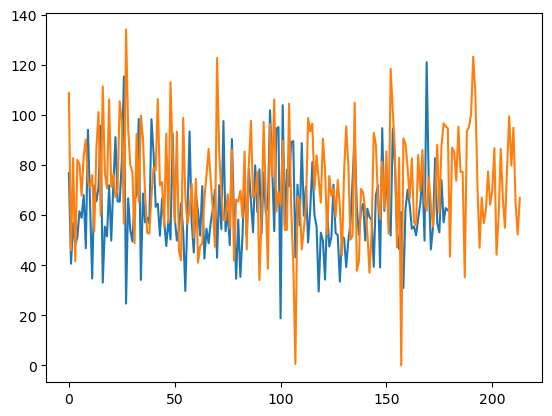

In [26]:
#%matplotlib inline
plt.plot(np.sum(spcomps_r_f,axis=1))
plt.plot(np.sum(spcomps_m_warp_f,axis=1))

In [9]:
len(match_dict1['Mrefs'])

70

In [10]:
print(match_dict1)

{'Srefs': [0, 7, 9, 12, 14, 15, 21, 22, 25, 26, 27, 31, 32, 33, 34, 37, 38, 39, 40, 41, 43, 45, 46, 49, 50, 54, 55, 57, 58, 60, 61, 63, 65, 67, 70, 71, 72, 74, 75, 81, 85, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 102, 107, 108, 109, 112, 113, 115, 118, 119, 120, 123, 126, 131, 132, 134, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 157, 159, 160, 161, 162, 163, 164, 169, 170, 171, 172, 173, 174, 176, 177], 'Smovs': [3, 8, 12, 17, 19, 24, 25, 26, 27, 28, 29, 31, 32, 34, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 54, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 95, 97, 99, 102, 104, 105, 107, 108, 109, 110, 111, 113, 114, 117, 118, 119, 120, 121, 122, 124, 125, 144, 145, 150, 152, 153, 154, 157, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172, 174, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211], 'Mrefs':

In [12]:
plt.plot(np.array([len(x) for x in match_dict1['Mrefs']]),np.array([len(x) for x in match_dict1['Mmovs']]))

In [15]:
np.array([len(x) for x in match_dict1['Mrefs']])

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [16]:
np.array([len(x) for x in match_dict1['Mmovs']])

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1])

In [31]:
viewer.layers['cells ref'].colormap.name == 'magenta'

True

In [17]:
np.array([len(x) for x in match_dict1['Mrefs']]) + np.array([len(x) for x in match_dict1['Mmovs']])

array([2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 3, 2, 2])

In [29]:
viewer.layers['cells ref'].colormap = 'magenta'

In [11]:
images_r.shape

(169, 440, 498, 21)

In [12]:
images_m_rot.shape

(69, 440, 498, 21)

In [18]:
(images_r.shape[0],) + images_m_rot.shape

(169, 69, 440, 498, 21)

In [20]:
images_r_b = np.broadcast_to(images_r,(images_m_rot.shape[0],) + images_r.shape)
print(images_r_b.shape)
images_m_rot_b = np.broadcast_to(images_m_rot,(images_r.shape[0],) + images_m_rot.shape)
print(images_m_rot_b.shape)
images_m_warp_b = np.broadcast_to(images_m_warp,(images_r.shape[0],) + images_m_warp.shape)
print(images_m_warp_b.shape)

(69, 169, 440, 498, 21)
(169, 69, 440, 498, 21)
(169, 69, 440, 498, 21)


In [19]:
images_m_rot_b = np.broadcast_to(images_m_rot,(images_r.shape[0],) + images_m_rot.shape)
images_m_rot_b.shape

(169, 69, 440, 498, 21)

In [16]:
viewer = napari.Viewer()
viewer.add_image(images_r_b.transpose([0,1,4,2,3]),name='cells ref',colormap='gray')
viewer.add_image(images_m_rot_b.transpose([1,0,4,2,3]),name='cells mov',colormap='gray')

/mnt/colab/colab_shared/anaconda3/envs/caiman_test/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)


<Image layer 'cells mov' at 0x7fa478e1a990>